# Gaussian Process for sparse spatial data 

Thus far we've experimented with Gaussian Process regression using a 1 dimension function -- a time series, for our purposes.  But Gaussian Processes can be applied to multiple dimensions and can be used for modeling spatial fields similar to Kriging.  Kriging is a geostatistical tool that models a (spatial) process as a combination of a mean or trend and a random process with (spatial) autocorrelation.  One can see the similarity with how Gaussian Processes and their kernels work!  Gaussian Process regression is a Bayesian process, however, whereas Kriging is usually a frequentist approach that does the modeling of the process directly from the observations.  Kriging uses a [variogram]() to model the spatial structure, which provides the covariance information, while Gaussian Processes use the kernel as the covariance function.  For kriging in Python, you can use [scikit-gstat](https://scikit-gstat.readthedocs.io/en/latest/) or [PyKrige](https://github.com/GeoStat-Framework/PyKrige).

Here's we'll see a few examples of using Gaussian Process to reconstruct a complete 2D spatial field from limited observations of that field.  At the end of this notebook is also a tractable (runs in several minutes) of training on a large sample from one field and using that model to predict or recosntruct a different (although related) field from more limited observations.  Be aware that Gaussian Processes are computationally intensive, so fitting models to large spatial datasets may simply not be practical. 

Let's get our libraries, including Cartopy for mapping.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import CenteredNorm

# you can omit the line below if you'd like, but I really don't like the default fonts in Python, so I switch to Helvetica
# plt.rcParams['font.family'] = 'Helvetica'

import cartopy # base Cartopy
import cartopy.crs as ccrs # shortcut to the coordinate reference system
import cartopy.feature as cfeature # add map features


We'll get our Gaussian Process modules from scikit-learn again:

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


We're going to create a simulated Gaussian field and then demonstrate how we can make limited observations of the field, train our Gaussian Process model, and then recover a posterior complete field that is very similar to the 'true' field we started with.  This is a somewhat 'too easy' test, as we're creating a 2D Gaussian field and then applying a Gaussian Process to the reconstruction of that field, but this will serve as a useful demonstration. 

In [5]:
# first, write a function that will create a smmoth anisotropic (or eliptical) and off-center Gaussian field  based on a set of coordinates in 'X'
def make_spatial_field(X):
    return np.exp(-((X[:, 0] - 0.7) ** 2 / 0.1 + (X[:, 1] - 0.5) ** 2 / 0.02))

# create a 2D grid of points X1 [0, 1] and X2[ 0, 1] with 100 coordinates in each of those dimensions - we'll define our 'true' field on this simple 1x1 grid
x1 = np.linspace(0, 1, 100) # 100 coordinates between 0 and 1 - this makes it easy to get random locations using the uniform distribution
x2 = np.linspace(0, 1, 100) # 100 coordinates
X1, X2 = np.meshgrid(x1, x2) # X1 and X2 are now both 100 x 100 arrays describing the paired coordinates at each location in the regular 2D grid
X_grid = np.vstack([X1.ravel(), X2.ravel()]).T # X_grid is now a long 2 column strung-out-vector of all the X1,X2 coordinate pairs, so 10000 x 2 columns

# Generate the true function values for that entire 10,000 member grid
y_true_grid = make_spatial_field(X_grid) # create an exponential function based on coordinate pairs, this returns 2 columns for simplicity although there is probably a better way to do this
y_true_grid_reshaped = y_true_grid.reshape(X1.shape) # now reshape that strung-out-vector back into a complete 2D grid

# sample randomly from the true field to mimic sparse observations of that field without noise
n_observations = 50
np.random.seed(1999) # for reproducibility, but try different seed numbers here to see a range of behaviors 
X_train = np.random.rand(n_observations, 2)  # Random 2D locations for observations using a draw from a uniform distribution [0,1] as it matches the artificial coordinate system

# generate our simulated data now for just the training points using the function again -  probably a better way to do this from the true_grid, but this is easy and works
y_train = make_spatial_field(X_train)

# set a constant and an RBF kernel - the RBF kernel now has 2 different initial length scales because we know the field is anisotropic - but what if we didn't? 
# from the scikit-learn documentation: 'If [length scale is] an array, an anisotropic kernel is used where each dimension of l defines the length-scale of the respective feature dimension.'
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[0.1, 0.5], length_scale_bounds=(1e-3, 1e3)) # make the starting value longer in X1 than X2 based on our knowledge of the system

# create the Gaussian Process regressor object
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# fit the gp model on the limited 'observed' data
gp.fit(X_train, y_train)

# ... then predict the values of the field at all the grid point values (10,000 of them) and return the posterior and the uncertainty
y_pred, sigma = gp.predict(X_grid, return_std=True)

# reshape posterior (the prediction) back to the grid for plotting
y_pred_grid = y_pred.reshape(X1.shape)
sigma_grid = sigma.reshape(X1.shape)

# calculate the difference between the true field and the posterior field
difference_grid = y_pred_grid - y_true_grid_reshaped


Let's now make some plots of the 'true' (simulated) field, the 'observations' of that field, the posterior or reconstructed field, and the difference between true and reconstructed:

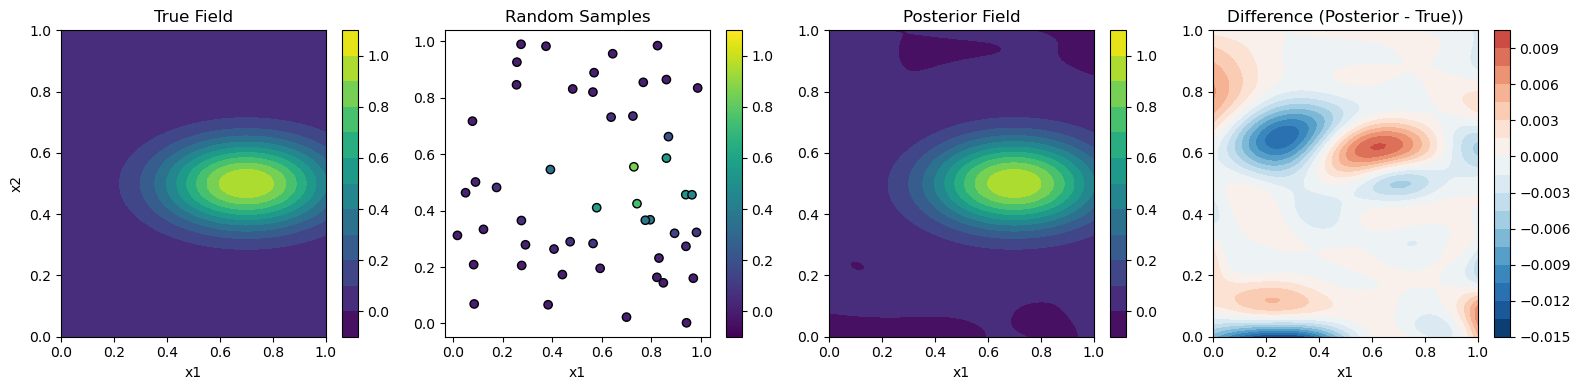

In [7]:
# get a common vmin and vmax so we can set consistent levels and colorbars
# vmin = min(y_true_grid.min(), y_train.min(), y_pred.min()) # this automatically sets vmin
# vmax = max(y_true_grid.max(), y_train.max(), y_pred.max()) # this automatically sets vmax
vmin = -0.1 # or manually set vmin based on first seeing the minimum values across 3 subplots
vmax = 1.1  # or manually set vmax based on first seeing the maximum values across 3 subplots
norm = colors.Normalize(vmin=vmin, vmax=vmax, clip=True) # normalize the colormap for consistency
levels = np.linspace(vmin, vmax, 13) # set levels based on vmin and vmax so that colorbars are uniform across 3 plots

# plot the True Field, the random observations, the Posterior Field, and their difference
plt.figure(figsize=(16, 4))

# true field
plt.subplot(1, 4, 1)
contour1 = plt.contourf(X1, X2, y_true_grid_reshaped, cmap='viridis',levels=levels,vmin=vmin, vmax=vmax,norm=norm)
plt.colorbar(contour1)
plt.title('True Field')
plt.xlabel('x1')
plt.ylabel('x2')

# observations, colored appropriately using y_train to get the colors
plt.subplot(1, 4, 2)
scatter = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', edgecolor='k',vmin=vmin, vmax=vmax)
plt.colorbar(scatter)
plt.title('Random Samples')
plt.xlabel('x1')

# the posterior field
plt.subplot(1, 4, 3)
contour2 = plt.contourf(X1, X2, y_pred_grid, cmap='viridis',levels=levels,vmin=vmin, vmax=vmax,norm=norm)
plt.colorbar(contour2)
plt.title('Posterior Field')
plt.xlabel('x1')

# plot the difference between the true field and the posterior field
plt.subplot(1, 4, 4)
contour3 = plt.contourf(X1, X2, difference_grid, cmap='RdBu_r', levels=21, norm=CenteredNorm()) # center the colorbar at zero (white)
plt.colorbar(contour3)
plt.title('Difference (Posterior - True))')
plt.xlabel('x1')

plt.tight_layout()
plt.show()

## A real SST field

Let's use the same approach on a real SST field.  We'll once again get our Hadley ISST data using xarray and create a DJF average for the tropical Pacific.  Unlike the previous EOF notebook, we'll restrict outselves to just the tropical domain (20N to 20S) to make the data a bit more computationally tractable.

In [17]:
# open our netcdf file into a DataSet and take a look:
ds = xr.open_dataset(r"C:\Users\mayae\Documents\GitHub\geog696f_space_time_methods\07_reduced_space\HadISST_sst.nc") 

# pull out sst only as a DataArray
sst = ds.sst

# deal with missing and negative values in SST
sst = sst.where(sst >= -4, np.nan) 
nan_mask = sst.isnull().any(dim='time')
sst = sst.where(~nan_mask, np.nan)

# change the longitudes from -180,180 to 0,360 
sst = sst.assign_coords(longitude=(sst.longitude % 360))
sst = sst.sortby(sst.longitude)

# latitude and longitude bounds for tropical and Pacific SST
min_lat = -20
max_lat = 20
min_lon = 120
max_lon = 280

# select a slice and overwrite sst with the output and then take a look
sst = sst.sel(longitude=slice(min_lon,max_lon),latitude=slice(max_lat,min_lat))

# calculate the monthly mean at each point and remove it from each point to get monthly anomalies (SSTA)
sst_clm = sst.groupby('time.month').mean(dim='time')
sst_anom = sst.groupby('time.month') - sst_clm

# Calculate the 3-month rolling mean and keep a winter (DJF) mean value
sst_ = sst_anom.rolling(time=3).mean(skipna=True)
djf = sst_[sst_.time.dt.month == 2]
djf = djf.drop_isel(time=0) # remove incomplete year 


Let's pull out a single year -- 1998.  December 1997 through February 1998 was the peak of one of the strongest El Nino events on record.  

In [20]:
djf_1998 = djf.sel(time='1998').squeeze() # squeeze out the singleton dimension here
djf_1998


<xarray.DataArray 'sst' (latitude: 40, longitude: 160)> Size: 26kB
array([[0.76171815, 0.7421888 , 0.83703995, ..., 0.50634706, 0.4272849 ,
        0.39425468],
       [0.7837944 , 0.7344774 , 0.74723816, ..., 0.5951538 , 0.56929463,
        0.53032875],
       [0.8267905 ,        nan, 0.70648   , ..., 0.63493794, 0.63737047,
        0.59971493],
       ...,
       [0.22826195, 0.16830382, 0.0703284 , ..., 0.8731766 , 0.8438778 ,
        1.0083339 ],
       [0.17369144, 0.15716808,        nan, ..., 0.7142665 , 0.64027977,
        0.7399591 ],
       [0.15990703,        nan,        nan, ..., 0.53105676, 0.5477003 ,
        0.6241417 ]], dtype=float32)
Coordinates:
    time       datetime64[ns] 8B 1998-02-15
  * latitude   (latitude) float32 160B 19.5 18.5 17.5 16.5 ... -17.5 -18.5 -19.5
  * longitude  (longitude) float32 640B 120.5 121.5 122.5 ... 277.5 278.5 279.5
    month      int64 8B 2

Let's now setup our Gaussian Process regression for DJF 1997-1998 in the tropical Pacific.  We'll first pull out the latitude and longitude values and the SST values to build our training set.  We use `.meshgrid` from Numpy to create the corresponding longitude and latitudes at each grid point (you can see lon_grid and lat_grid are both 40 by 160, each containing the longitude or latitude for each grid point in 2D space) and then create a strung-out-vector of 2 columns to pass to the Gaussian Process regressor (note again that `.fit` is going to expect the data as 'n_samples, n_features' according to the scikit-learn documentation, so each column here is a feature - a grid point location of longitude and latitude).  

In [23]:
# setup the data for the Gaussian Process regression
latitudes = djf_1998['latitude'].values
longitudes = djf_1998['longitude'].values
sst_values = djf_1998.values.flatten()

# create a full set of paired longitude and latitude coordinates for each grid point in our domain
lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)
coords = np.column_stack([lon_grid.ravel(), lat_grid.ravel()])


Now let's get a small random sample from the SST field that will serve as our observations.  We will use `np.random.choice` to select index values of n_samples, then apply that random index to the coordinate training (e.g. the longitude and latitude coordinates) and the value training sets. 

In [26]:

# get a random set of observations across the field
n_samples = 100 # the quality of the single year GP kriging will be very sensitive to this
indices = np.random.choice(len(coords), size=n_samples, replace=False)
X_train = coords[indices]  # these are the coordinates (lon, lat) of our observations 
y_train = sst_values[indices]  # and these are corresponding values


We'll once again define an anisotropic RBF kernel with two starting length scales - since this is the tropical Pacific, we might expect the longitude length scale should be more stretched or extended than the latitude one.  We'll also limit our training dataset now for the fit to only locations that have a valid (non-NaN) SST value (e.g. we will not use points that happened to come from contients, as the fit will fail).  We'll `.fit` our model using the limited observations only.  

We'll then use that model fit to predict SST values at all the points in the field (note that this will predict SST values for the continents - I could and should probably mask and make these NaN, but for now I'll  just cover them with continents).  We'll then turn our posterior reconstruction and uncertainty into DataArrays again (they come out of the Gaussian Process fit and predict as Numpy arrays):

In [29]:
# define the kernel and create the Gussian Process object
kernel = C(1.0) * RBF(length_scale=[100,20]) # units are degrees of longitude and latitude, so use those to guide length scale initialization - could also add e.g. length_scale_bounds=(1.0, 1000.0) 
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50)

# remove any NaN values from the training data that come from points placed on continents - maybe not the best way to do this, but the easiest for now
valid_indices = ~np.isnan(y_train)
X_train_valid = X_train[valid_indices]
y_train_valid = y_train[valid_indices]

# Fit the Gaussian Process model
gp.fit(X_train_valid, y_train_valid)

# Prepare the full grid for predictions
X_pred = coords  # Coordinates of all grid points (lon, lat)

# Make predictions on the full field
y_pred, y_std = gp.predict(X_pred, return_std=True)

# Reshape the predicted values back to the original shape
sst_pred = y_pred.reshape(djf_1998.shape)
sst_std = y_std.reshape(djf_1998.shape)

# Convert the predictions back to an xarray DataArray for easier handling
sst_pred_da = xr.DataArray(sst_pred, coords=djf_1998.coords, dims=djf_1998.dims)
sst_std_da = xr.DataArray(sst_std, coords=djf_1998.coords, dims=djf_1998.dims)


Let's do some plots again - once again we'll look at the known DJF 1997-1998 SST anomaly field, where our 'observations' occur, the posterior reconstructed field, and the difference or error:

C:\Users\mayae\anaconda3\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\Users\mayae\anaconda3\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


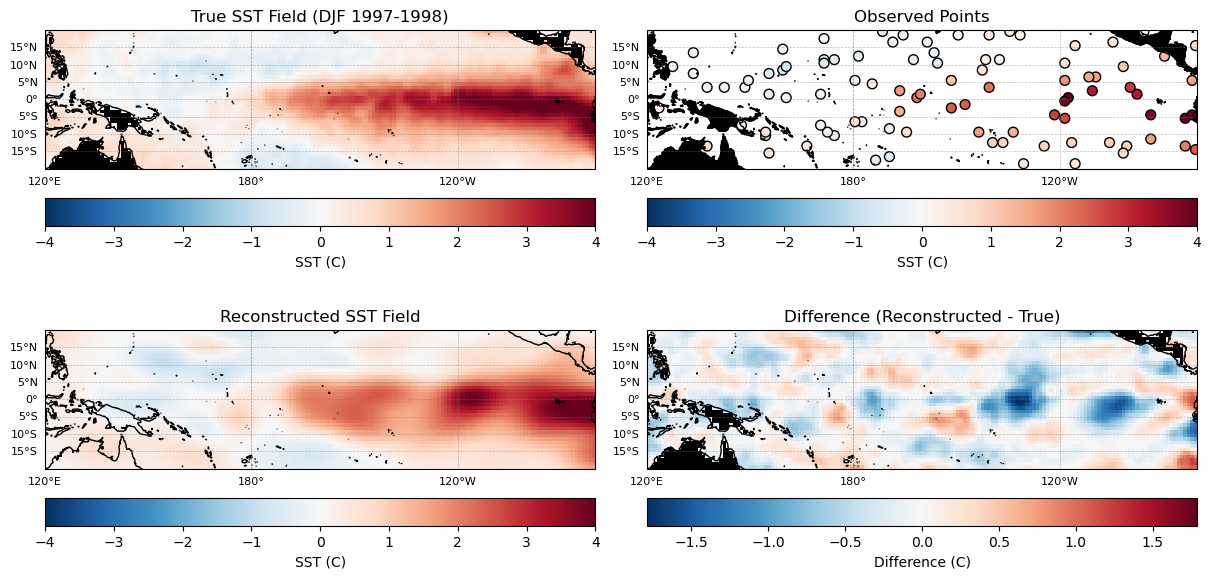

In [31]:
difference = sst_pred_da - djf_1998

# define the projection for all subplots - we'll use Miller centered on the tropical Pacific 
projection = ccrs.Miller(central_longitude=260)

# create a figure with 4 subplots, using the same projection for each
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6), subplot_kw={'projection': projection}, constrained_layout=True)
axs = axs.flatten() # flatten the axes handle for simpler referencing

# plot the true field
im1 = axs[0].pcolormesh(djf_1998['longitude'], djf_1998['latitude'], djf_1998.squeeze(), cmap='RdBu_r', shading='auto', vmin=-4, vmax=4, transform=ccrs.PlateCarree()) # squeeze the singleton dimension for plotting
axs[0].set_title('True SST Field (DJF 1997-1998)')
axs[0].coastlines()
axs[0].add_feature(cfeature.LAND, color='black')
axs[0].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
plt.colorbar(im1, ax=axs[0], orientation='horizontal', label='SST (C)')

# plot the observations 
sc = axs[1].scatter(X_train_valid[:, 0], X_train_valid[:, 1],c=y_train_valid,cmap='RdBu_r',edgecolor='k',s=50,marker='o', vmin=-4, vmax=4, transform=ccrs.PlateCarree())
axs[1].set_title('Observed Points')
axs[1].coastlines()
axs[1].add_feature(cfeature.LAND, color='black')
axs[1].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
plt.colorbar(sc, ax=axs[1], orientation='horizontal', label='SST (C)')

# plot the reconstructed field
im2 = axs[2].pcolormesh(sst_pred_da['longitude'], sst_pred_da['latitude'], sst_pred_da.squeeze(), cmap='RdBu_r', shading='auto',  vmin=-4, vmax=4, transform=ccrs.PlateCarree())
axs[2].set_title('Reconstructed SST Field')
axs[2].coastlines()
axs[2].add_feature(cfeature.LAND, color='black')
axs[2].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
plt.colorbar(im2, ax=axs[2], orientation='horizontal', label='SST (C)')

# plot the difference between the true and reconstructed fields
im3 = axs[3].pcolormesh(difference['longitude'], difference['latitude'], difference.squeeze(), cmap='RdBu_r', shading='auto', norm=CenteredNorm(), transform=ccrs.PlateCarree())
axs[3].set_title('Difference (Reconstructed - True)')
axs[3].coastlines()
axs[3].add_feature(cfeature.LAND, color='black')
axs[3].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
plt.colorbar(im3, ax=axs[3], orientation='horizontal', label='Difference (C)')

for ax in axs:
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 8, 'color': 'black'}
    gl.ylabel_style = {'size': 8, 'color': 'black'}

plt.show()

The posterior reconstructed field generally captures the assymetric warming pattern seen in the full SST field.  However, it is too 'spotty' and too warm in regions with no observations in the warmest parts of if the eastern equatorial Pacific.  The length scale hyperparameters of the posterior are also quite short:

In [35]:
gp.kernel_

1.08**2 * RBF(length_scale=[8.52, 4.92])

## Next Steps
1. Experiment with the settings for the RBF kernel - above I include two dimensions, again with a longer initial length scale for the zonal (longitude) dimension vs the medidional (latitude) dimension.  What if I don't do that? How does that effect the shape of the SST reconstruction?
2. Incrementally increase the number of observations - how does this affect the posterior reconstructed field? 
3. Similarly, experiment with using some _different_ classes of kernels - you can see the options [here](https://scikit-learn.org/1.5/modules/gaussian_process.html#kernels-for-gaussian-processes).  For instance, what happens if you use the Matern kernel instead of the RBF? 


The section below is experimental.  In theory, we should be able to get a better posterior reconstruction if the model is fit on a larger set of data.  Unfortunately, Gaussian Processes are so computationally expensive that training the model on e.g. the full field from a different ENSO year (let alone the full dataset) would take an extremely long time to complete (and might even crash your kernel).  Here is a compromise, where we train on a large subset (1000 or greater points) and then predict on a limited set of points from 1998 again.  

## Training on a subset of a different year


In [37]:
# extract just the 1983 data -- another El Nino winter! - from the dataset
djf_1983 = djf.sel(time='1983')

# prepare coordinates and values for training
latitudes_1983 = djf_1983['latitude'].values
longitudes_1983 = djf_1983['longitude'].values
sst_values_1983 = djf_1983.values.flatten()

# create a full set of paired longitude and latitude coordinates for each grid point in 1983
lon_grid_1983, lat_grid_1983 = np.meshgrid(longitudes_1983, latitudes_1983)
coords_1983 = np.column_stack([lon_grid_1983.ravel(), lat_grid_1983.ravel()])

# get a larger subsample for training with 1983
n_samples_1983 = 3000  # tried 1000 and 2000; 5000 still takes a very long time! 
indices_1983 = np.random.choice(len(coords_1983), size=n_samples_1983, replace=False)
X_train_1983 = coords_1983[indices_1983]  # Coordinates (lon, lat) of observations
y_train_1983 = sst_values_1983[indices_1983]  # Corresponding SST values

# remove NaN values from the training data due to selecting land points
valid_indices_1983 = ~np.isnan(y_train_1983)
X_train_1983_valid = X_train_1983[valid_indices_1983]
y_train_1983_valid = y_train_1983[valid_indices_1983]

# define the kernel and create the Gaussian Process object
kernel = C(1.0) * RBF(length_scale=[100, 20],length_scale_bounds=(2.0, 1000.0)) # forcing the length scale to be longer helps improve the reconstruction, but forcing it to be very long gives you a very smooth field
gp0 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# fit the GP model using the (valid) training data from 1983
gp0.fit(X_train_1983_valid, y_train_1983_valid)

# extract 1998 data for prediction and reconstruction
djf_1998 = djf.sel(time='1998')
latitudes_1998 = djf_1998['latitude'].values
longitudes_1998 = djf_1998['longitude'].values
sst_values_1998 = djf_1998.values.flatten()

# create the full grid of coordinates for 1998
lon_grid_1998, lat_grid_1998 = np.meshgrid(longitudes_1998, latitudes_1998)
coords_1998 = np.column_stack([lon_grid_1998.ravel(), lat_grid_1998.ravel()])

# select the limited random set of observations for 1998
n_samples_1998 = 100  
indices_1998 = np.random.choice(len(coords_1998), size=n_samples_1998, replace=False)
X_train_1998 = coords_1998[indices_1998]
y_train_1998 = sst_values_1998[indices_1998]

# remove NaN values from the limited observations for 1998
valid_indices_1998 = ~np.isnan(y_train_1998)
X_train_1998_valid = X_train_1998[valid_indices_1998]
y_train_1998_valid = y_train_1998[valid_indices_1998]

# use the pre-trained GP model from 1983 to predict the full 1998 field from the limited observations
X_pred_1998 = coords_1998  # Full grid of coordinates for 1998

# Make predictions on the full field for 1998 using the GP model trained on 1983 data
y_pred_1998, y_std_1998 = gp0.predict(X_pred_1998, return_std=True)

# Reshape the predicted values back to the original shape of the 1998 data
sst_pred_1998 = y_pred_1998.reshape(djf_1998.shape)
sst_std_1998 = y_std_1998.reshape(djf_1998.shape)

# Convert the predictions back to an xarray DataArray for easier handling
sst_pred_da_1998 = xr.DataArray(sst_pred_1998, coords=djf_1998.coords, dims=djf_1998.dims)
sst_std_da_1998 = xr.DataArray(sst_std_1998, coords=djf_1998.coords, dims=djf_1998.dims)

# for 1000 training points, time for this code block is between 15 seconds and 1 minute ?!
# for 2000 training points, time for this code block is 50 seconds to ~5 minutes
# for 3000 training points, time for this code block is >2 minutes to ~6 minutes

C:\Users\mayae\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 2.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\mayae\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 2.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Does the posterior hyperparameters look any better? Without additional constraints, the posterior hyperparameters appear to find a lower bound - why? 

In [39]:
gp0.kernel_

0.903**2 * RBF(length_scale=[2, 2])

Plotting code for the model fitting and reconstruction above - even with a larger training, the lack of observations in the warm eastern equatorial Pacific still results in isolated area of too warm reconstructed temperatures. 

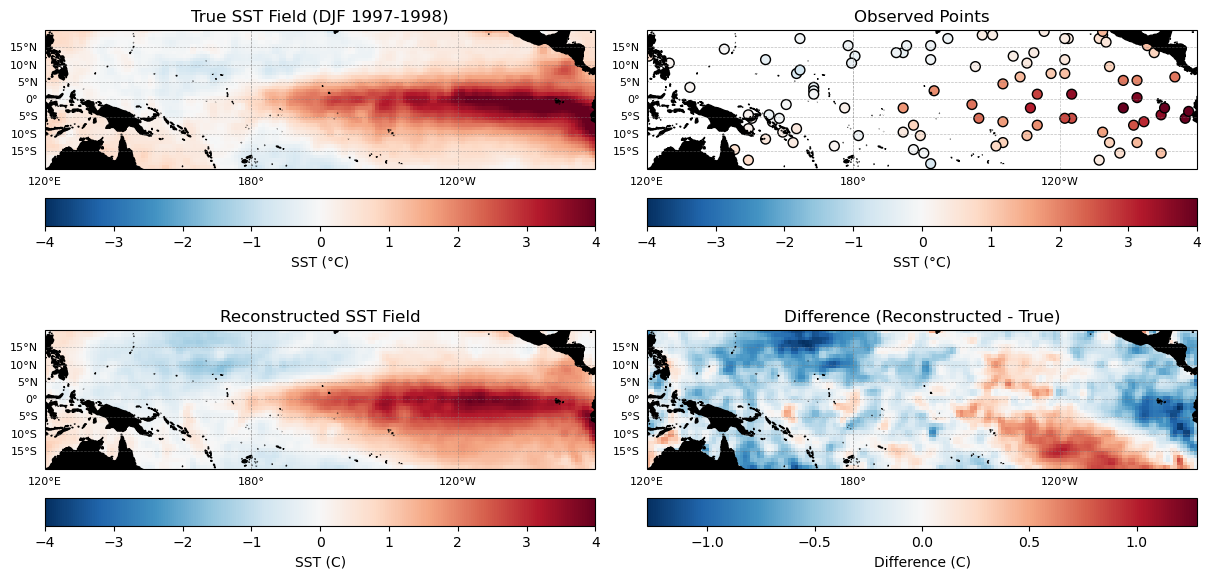

In [41]:
difference = sst_pred_da_1998 - djf_1998

# same  projection for all subplots
projection = ccrs.Miller(central_longitude=260)

# this seems to work better than the old way of doing it? 
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='black')

# create a figure with 4 subplots, using the same projection for each
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6), subplot_kw={'projection': projection}, constrained_layout=True)
axs = axs.flatten()  # Flatten the axes handle for simpler reference

# the known field
pc1 = axs[0].pcolormesh(djf_1998['longitude'], djf_1998['latitude'], djf_1998.squeeze(), cmap='RdBu_r', shading='auto', vmin=-4, vmax=4, transform=ccrs.PlateCarree())
axs[0].set_title('True SST Field (DJF 1997-1998)')
axs[0].coastlines()
axs[0].add_feature(land_feature)
axs[0].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
plt.colorbar(pc1, ax=axs[0], orientation='horizontal', label='SST (°C)')

# observations
sc = axs[1].scatter(X_train_1998_valid[:, 0], X_train_1998_valid[:, 1], c=y_train_1998_valid, cmap='RdBu_r',edgecolor='k', s=50, marker='o', vmin=-4, vmax=4, transform=ccrs.PlateCarree())
axs[1].set_title('Observed Points')
axs[1].coastlines()
axs[1].add_feature(land_feature)
axs[1].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
plt.colorbar(sc, ax=axs[1], orientation='horizontal', label='SST (°C)')

#  the reconstructed field
pc2 = axs[2].pcolormesh(sst_pred_da_1998['longitude'], sst_pred_da_1998['latitude'], sst_pred_da_1998.squeeze(),cmap='RdBu_r', shading='auto', vmin=-4, vmax=4, transform=ccrs.PlateCarree())
axs[2].set_title('Reconstructed SST Field')
axs[2].coastlines()
axs[2].add_feature(land_feature)
axs[2].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
plt.colorbar(pc2, ax=axs[2], orientation='horizontal', label='SST (C)')

# Plot the difference between the true and reconstructed fields
pc3 = axs[3].pcolormesh(difference['longitude'], difference['latitude'], difference.squeeze(),cmap='RdBu_r', shading='auto', norm=CenteredNorm(), transform=ccrs.PlateCarree())
axs[3].set_title('Difference (Reconstructed - True)')
axs[3].coastlines()
axs[3].add_feature(land_feature)
axs[3].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
plt.colorbar(pc3, ax=axs[3], orientation='horizontal', label='Difference (C)')

for ax in axs:
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 8, 'color': 'black'}
    gl.ylabel_style = {'size': 8, 'color': 'black'}

plt.show()
